In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


- next meeting: 18, Monday 
- Kai's Job: 
    - X1.set missing to NaN 
    - X2. data cleansing- interpolation; moving average ; 
    - X3. sample class and function for each stage (outline)
    - X4. plots; 5. LSTM coding; 6. Adfuller iwth different IC;
    - 5. LSTM model construction
    - 6. MAE/RMSE error evaluation
    - PS. How to train a model that accepts missing values?(https://machinelearningmastery.com/handle-missing-timesteps-sequence-prediction-problems-python/)
    - PS2. otehr possible imputation methods: KNN, stochastic regression
    - PS3. possible combination of LSTM and VAR model?
- Bennet's Job:
    - 1. data cleansing- timeoftheyear/ imputations 
    - 2. Get familiar with pandas and functions
    - 3. ac/pac/auto-corr-residual plots.
    - 4. R code for data preprocessing in the other kind of datasets (except Aquifer waterbody)
    - 5. record locations of missing values in original dataset(CSV).
    - 6. dump figures (png) 
    - PS. how to calculate rmse depnding on imputed values
    - PS2. data splitting ratio for train/validation/test: 8/1/1
    
    
- Together: 
    - 1. look up python package that help read R code inbody.
    - 2. VAR model (Rstudio/python)(adftest/ take differences/ cointegration check/ VAR_1stDiff|VAR_Ori|VECM model choice via (lag choice and coefs estimation)/ (adjusted-)portmanteau test /inference and performance.)

In [2]:
import os
for dirname, _, filenames, in os.walk('/Users/mbpr/Downloads/acea-water-prediction/'):
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date 
import math
import missingno as mnso

In [4]:
import tensorflow as tf
import keras
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit

# Functions Plotting

In [64]:
def aquifer_feature_plots(df):
    """Plot each group of features of aquifer dataframe"""
    # Alternative: put Date into columns in df, then...
    # sns.relplot(x='Date', y='value', col='Feature', col_wrap=5, kind='line', 
    #             data = df.filter(regex='Date|^Rainfall_.+').melt(id_vars='Date', var_name='Feature'))
    # plt.suptitle('Rainfalls', y=1.02)
    # create Date column
    if not 'Date' in df.columns.values:
        df['Date'] = df.index
    # plot Rainfalls
    sns.relplot(x='Date', y='value', col='Feature', col_wrap=5, kind='line', 
                data = df.filter(regex='Date|^Rainfall_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Rainfalls', y=1.02)
    # plot gounrdwaters and Volumes
    sns.relplot(x='Date', y='value', hue='Feature', kind='line', 
                data = df.filter(regex='Date|^Depth_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Groundwaters', y=1.02)
    sns.relplot(x='Date', y='value', hue='Feature', kind='line', 
                data = df.filter(regex='Date|^Volume_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Volumes', y=1.02)
    # plot Temperatures
    sns.relplot(x='Date', y='value', col='Feature', kind='line', 
                data = df.filter(regex='Date|^Temperature.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Temperatures', y=1.02)
    # plot Hydrometry
    sns.relplot(x='Date', y='value', col='Feature', kind='line', 
                data = df.filter(regex='Date|^Hydrometry_.+').melt(
                        id_vars='Date', var_name='Feature', ignore_index=False))
    plt.suptitle('Hydrometries', y=1.02)
    plt.show()
    if 'Date' in df.columns.values:
        df.drop(columns='Date', inplace=True)

def missingval_plots(df):
    """
    Visualize index location of missin values of each feature.
    Doesn't work for 1-dim df.
    """
    # from matplotlib.colors import LinearSegmentedColormap
    # myColors = ((1.0, 1.0, 1.0, 1.0), (0.0, 0.0, 0.0, 1.0))
    # cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    g = sns.heatmap(df, cmap='Blues', cbar=True, yticklabels=df.index.values)
    # customize colorbar
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticklabels(['non-missing', 'missing'])
    # customize title
    ax.set_title('Distribution of Missing Values', fontsize=16)
    # customize font size in ticks
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    plt.show()

def rfft_plot(series):
    """plot real valued fourier transform to find most important frequency/periodicity"""
    fft = tf.signal.rfft(series)
    f_per_dataset = np.arange(0, len(fft))

    n_samples_d = len(series)
    d_per_year = 365.2524
    years_per_dataset = n_samples_d/(d_per_year)
    f_per_year = f_per_dataset/years_per_dataset

    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.ylim(0, 400)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
    _ = plt.xlabel('Frequency (log scale)')
    plt.show()

# Data Preprocessing

In [6]:
def fillna(data, approach, **kwargs):
    """fill nan with the specified approach."""
    if approach == 'constant':
        return data.fillna(-99999)
    elif approach == 'mean':
        return data.fillna(data.mean(axis=0, skipna=True))
    elif approach == 'median': 
        return data.fillna(data.median(axis=0, skipna=True))
    elif approach == 'interpolate':
        # data cannot contain datetime columns
        # kwargs: method, axis, limit, limit_direction, limit_area, inplace
        return data.interpolate(**kwargs)
    elif approach == 'movingavg':
        # kwargs: window, min_periods, center, win_type
        return data.fillna(data.rolling(**kwargs).mean())
    elif approach == 'regression':
        pass 
    elif approach == 'stochasticreg':
        pass
    elif approach == 'KNN':
        pass
    elif approach == 'LDA':
        pass
    else:
        raise ValueError('Keyword not found for approach')

def adftest(series, verbose=1, **kwargs):
    """adfuller + printing"""
    # kwargs: maxlag, regression, autolag
    from statsmodels.tsa.stattools import adfuller
    res = adfuller(series.values, **kwargs)
    if verbose:
        print('ADF Statistic: {:13f} \tp-value: {:10f}'.format(res[0], res[1]))
        if 'autolag' in kwargs.keys():
            print('IC: {:6s} \t\t\tbest_lag: {:9d}'.format(kwargs['autolag'], res[2]))
        print('Critical Values: ', end='')
        for key, value in res[4].items():
            print('{:2s}: {:>7.3f}\t'.format(key, value), end='')
    return res

# Feature Engineering

In [7]:
def TS_to_supervise(df, timestep=1, dropna=True):
    """
    Transform dataset into a format that is appropriate for supervised learning.
    Arguments:
        df: pd.DataFrame format dataset.
        lag: Number of lag observations as input (X).
        dropnan: Boolean whether or not to drop rows with NaN values.
    """
    col_name = df.columns.values
    collector = []
    for i in range(timestep, 0, -1):
        tmp = df.shift(i)
        tmp.columns = col_name + '(-{:s})'.format(str(i))
        collector.append(tmp)
    collector.append(df)
    df = pd.concat(collector, axis=1)
    if dropna:
        df.dropna(inplace=True)
    return df

def invert_diff(df_before_yhat, yhat, n_diff=1):
    """Recover corresponding value of prediction in differenced feature back to the one before diff()."""    
    try: 
        axis = 1 if df_before_yhat.shape[1] > 1 else 0
    except:
        axis = 0 
    if type(df_before_yhat) != np.ndarray:
        df_before_yhat = df_before_yhat.values
    array = np.concatenate((df_before_yhat, yhat), axis=0)

    for d in range(0, n_diff):
        array = array.cumsum(axis=axis)
    return array

def scale(train, val, test, approach='MinMax'):
    """scale train (and test) data via MinMaxScalar/StandardScalar"""
    if approach == 'MinMax':
        scaler = MinMaxScaler(feature_range=(-1, 1))
    elif approach == 'Standard':
        scaler == StandardScaler()
    # save DataFrame Info
    # fit and transform train
    scaler = scaler.fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns, index=train.index)
    # transform val/test
    val_scaled = pd.DataFrame(scaler.transform(val), columns=val.columns, index=val.index)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)
    return scaler, train_scaled, val_scaled, test_scaled


# Model Classes

In [23]:
# TODO: 3 Possible models: VECM model | VAR_original model | VAR_stationary model
class VAR:
    
    def __init__(self):
        pass 

# TODO: Sequence Prediction(aka One-step TS Forecasting) | Sequence-to-Sequence Prediction(aka Multi-step TS Forecasting)
# with one/three groundwater output(s) at a time.
# Note: the random initial conditions for an LSTM network can result in very different performance each time a 
# given configuration is trained.
class LSTM:    
    def __init__(self, batch_size, timestep, n_features, lstm_units=1, dense_units=3, masking=False):
        self.model = keras.models.Sequential()
        if masking: 
            self.model.add(keras.layers.Masking(mask_value=-99999,  
                                                batch_input_shape=(batch_size, timestep, n_features))) #???inpue_shape
        # stateful=True: do not reset states in every batch due to the non-independence among batches, ie, Time Series.
        self.model.add(keras.layers.LSTM(lstm_units, batch_input_shape=(batch_size, timestep, n_features), 
                                         stateful=True, name='lstm'))
        self.model.add(keras.layers.Dense(dense_units, name='dense'))
        self.model.compile(loss='mean_squared_error', optimizer='adam')

    def fit(self, X_train, y_train, batch_size, epochs, **kwargs):
        # batch_size refers to the one/multi-step ahead prediction
        for i in range(epochs):
            # turn shuffle off as this will break Time Series property
            self.model.fit(X_train, y_train, shuffle=False, batch_size=batch_size, **kwargs)
            # reset states after training of each epoch
            self.model.reset_states()
        # save final hidden states for further use
        self.model.predict(X_train, batch_size=batch_size)
        self.states = self.model.get_layer('lstm').states
        
    def predict(self, X_test, **kwargs):
        """
        Predict values on X_test based on fixed or rolling approach.
        (fixed approach:) predict each new time step one at a time from the test data, 
        """
        self.model.get_layer('lstm').states = self.states
        return self.model.predict(X_test, **kwargs) # input shape: [batch_size, timestep, features]
        
    def rolling_predict(self, X_test, **kwargs):
        """
        Predict values on X_test based on fixed or rolling approach.
        Require input arguments in kwargs.
        rolling: update the model each time step of the test data once prediction(s) at that time has been made.
        """
        self.states = self.model.get_layer('lstm').states
        predictions = []
        X_train_updater = np.copy(X_train)
        y_train_updater = np.copy(y_train)
        for i in range(len(X_test)):
            # update
            if i > 0: 
                self.update(**kwargs)
            # forecast
            yhat = self.model.predict(X_test) #???
            predictions.append(yhat)
            X_train_updater = X_train_updater.append() #???
            y_train_updater = y_train_updater.append() #???
        return predictions
    
    def update(self, X_train, y_train, batch_size, updates, mask=None):
        # split X_train, y_train and reshape
        # ???
        # re-train model
        for i in range(updates):
            self.fit(X_train, y_train, batch_size, epoch, mask)

# Main Code

## Aquifer: Auser
There are 5 different kinds of Depth_to_Groundwater_* variables, where SAL, PAG, CoS, DIEC stand for north systems and LT2 stands for south system. (south system is partially affected by the north ones).
The goal is to predict SAL, COS, and LT2.

In [69]:
dataset = 'Aquifer_Auser.csv'

# read dataset as DataFrame
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
#df = pd.read_csv("/kaggle/input/acea-water-prediction/"+dataset, index_col='Date', parse_dates=['Date'], date_parser=dateparse))
df = pd.read_csv("./data/"+dataset, index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df.index.freq = 'd'
df.sort_index(inplace=True)

display(df)

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
Date,,,,,,,,,,,,,,,,,,,,,
1998-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.20,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.40,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.40,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.75,0.0,23.75,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.20,-1.03
2020-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.35,0.0,24.30,-7189.406533,-7847.900,-9183.433333,-6115.40,-3158.0,0.21,-1.03
2020-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.75,0.0,24.55,-6829.936207,-7455.505,-8724.261667,-5809.63,-3000.1,0.23,-1.03


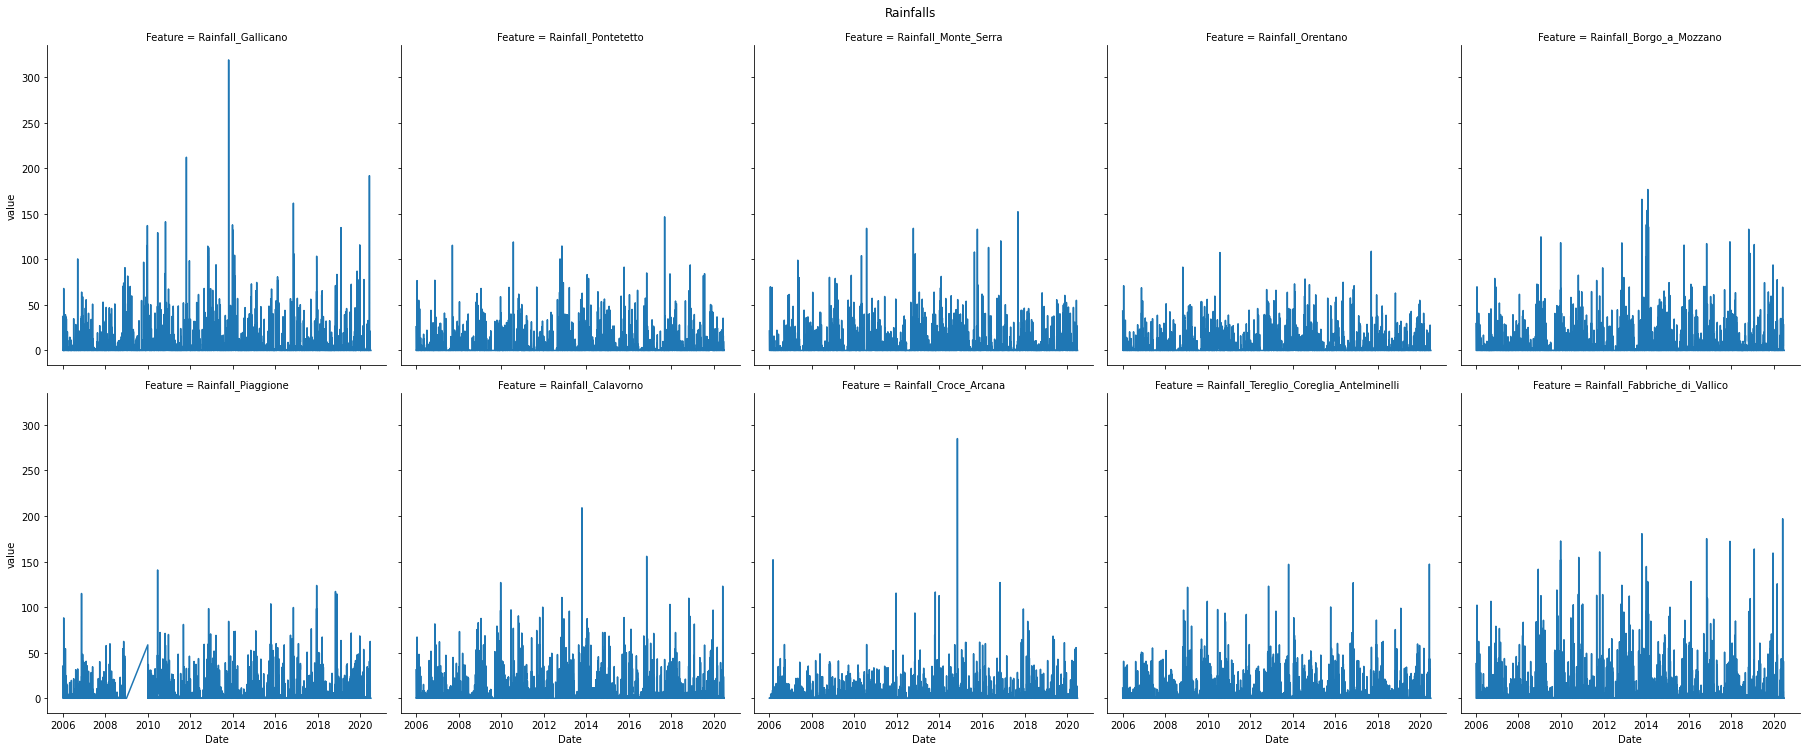

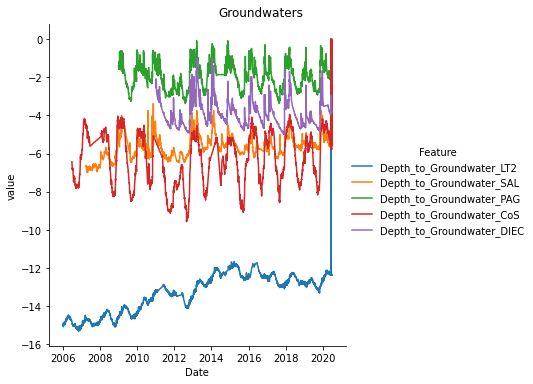

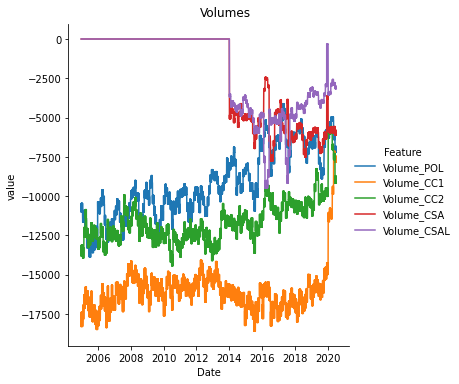

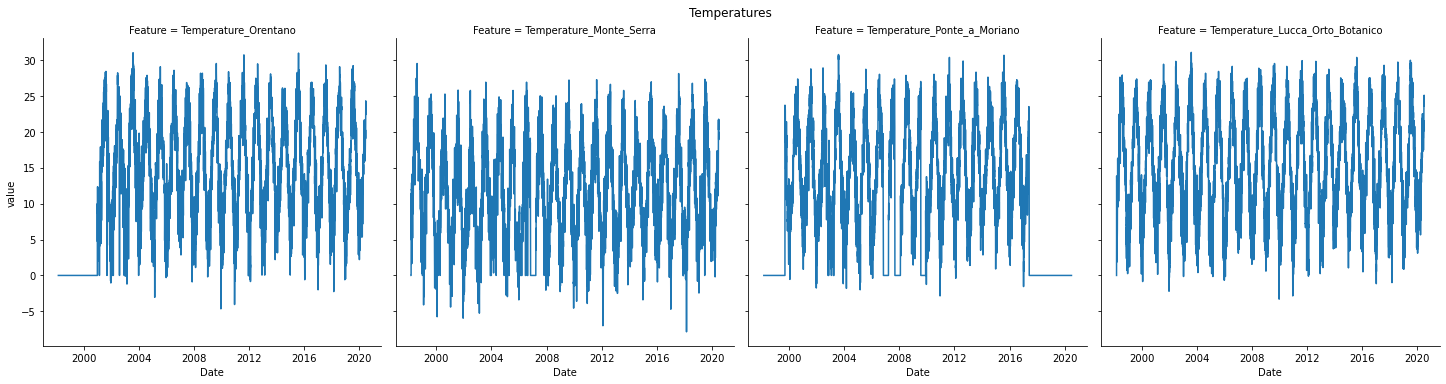

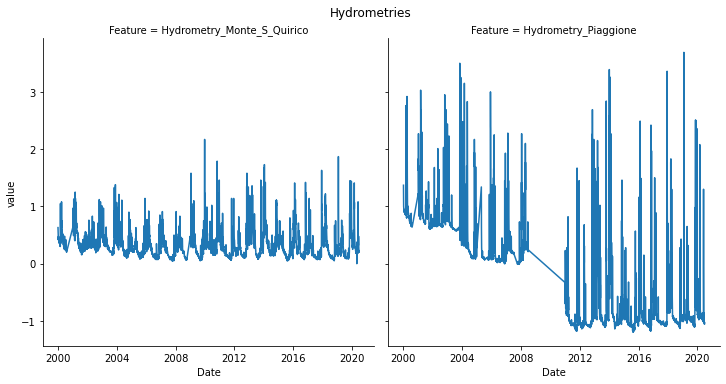

In [70]:
# basic plot of each feature
aquifer_feature_plots(df)

In [71]:
# basic plot of correlation between features


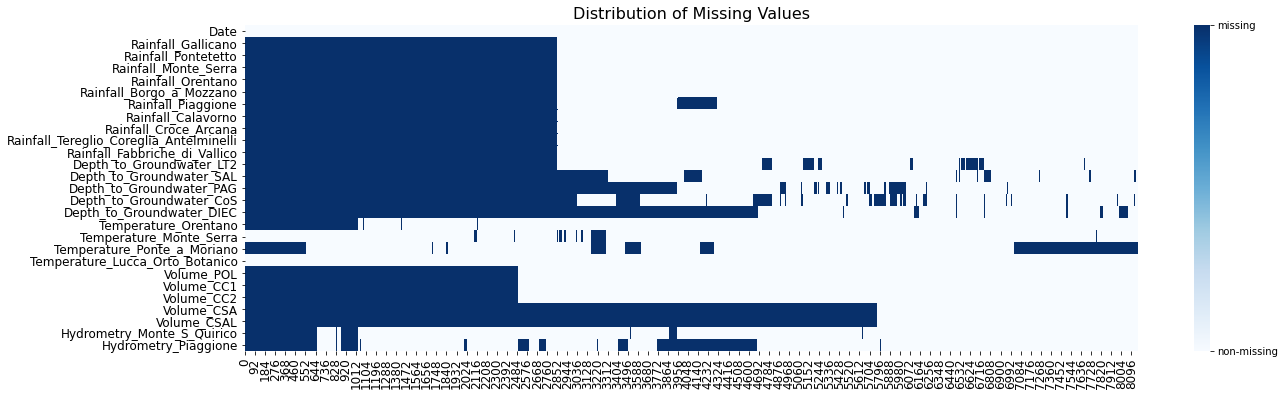

In [72]:
# Set weird values to nan
## set nan to Groundwater whose values are 0
df[df.filter(regex='Depth_*').columns] = df.filter(regex='Depth_*').replace(0, np.nan)
## set nan to Volume whose values are 0
df[df.filter(regex='Volume_*').columns] = df.filter(regex='Volume_*').replace(0, np.nan)
## set nan to Temperature whose values are 0
df[df.filter(regex='Temperature_*').columns] = df.filter(regex='Temperature_*').replace(0, np.nan)

# visual graph of nan locations for each field
missingval_plots(df.reset_index().T.isna())

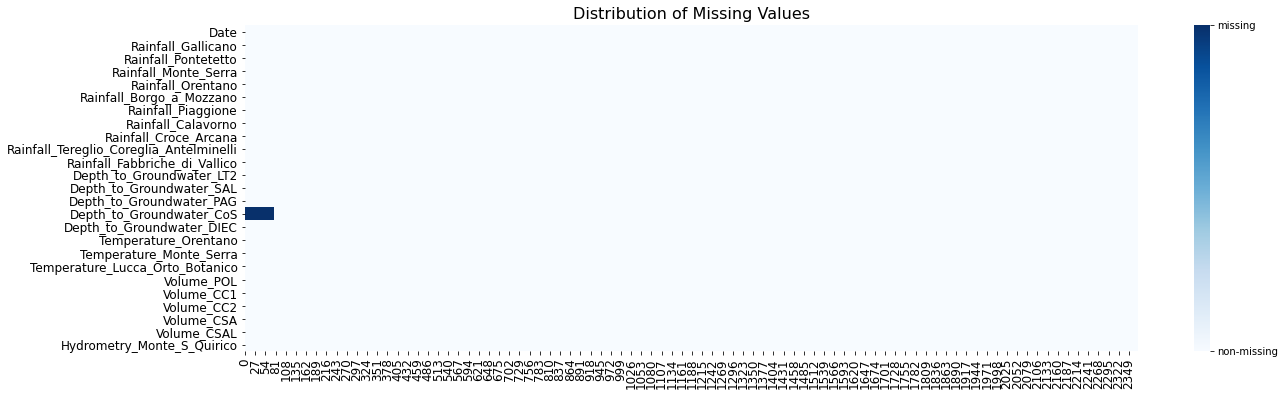

In [73]:
# Dealing with missing values

## drop old/unuseful data
todrop = df[df.Volume_CSA.isna()].index.max()
df = df[df.index > todrop].copy() # remaining data starts from 2014-01-01
## drop columns (to be further confirmed)
df.drop(columns=['Temperature_Ponte_a_Moriano', 'Hydrometry_Piaggione'], inplace=True)

## Record nan positions before imputation
#mask = df.isna()

## imputation
#nondate_cols = dfsmall.iloc[:, 2:-9].columns
dfimputed = df.copy()
tmp = fillna(dfimputed, 'interpolate', method='linear').copy()
dfimputed= tmp

## visual graph of nan locations 
missingval_plots(dfimputed.reset_index().T.isna())


In [74]:
todrop = dfimputed[dfimputed['Depth_to_Groundwater_CoS'].isna()].index.max()
dfimputed = dfimputed[dfimputed.index > todrop].copy()
assert dfimputed.isna().any().any() == False
print(dfimputed.shape)

#aquifer_feature_plots(dfimputed)

(2295, 24)


In [75]:
# Make it stationary: seasonality can be eliminated by using diff() or deducting a a seasonal pattern found by seasonal_decompose
## adftest
adftable = pd.DataFrame(columns=['AIC_5%level', 'AIC_bestlag', 'BIC_5%level', 'BIC_bestlag'])
for col in dfimputed.columns:
    row = []
    for autolag in ['AIC', 'BIC']:
        res = adftest(dfimputed[col], verbose=0, maxlag=30, regression='ct', autolag=autolag)
        sig = True if abs(res[0])>abs(res[4]['5%']) else False
        row.extend([sig, res[2]])
    adftable = adftable.append(pd.Series(row, index=adftable.columns, name=col))

display(adftable)

,AIC_5%level,AIC_bestlag,BIC_5%level,BIC_bestlag
Rainfall_Gallicano,True,18,True,0
Rainfall_Pontetetto,True,11,True,0
Rainfall_Monte_Serra,True,13,True,0
Rainfall_Orentano,True,20,True,0
Rainfall_Borgo_a_Mozzano,True,12,True,0
Rainfall_Piaggione,True,12,True,0
Rainfall_Calavorno,True,18,True,2
Rainfall_Croce_Arcana,True,0,True,0
Rainfall_Tereglio_Coreglia_Antelminelli,True,11,True,3
Rainfall_Fabbriche_di_Vallico,True,14,True,2


In [76]:
## (Cont'd) diff() on cols that do not pass the adftest. Here we adopt AIC.
dfstationary = dfimputed.copy()
I1 = adftable[adftable['AIC_5%level'] == False].index.values
dfstationary.loc[:,I1] = dfstationary[I1].diff()
dfstationary.dropna(inplace=True)

## adftest again
adftable = pd.DataFrame(columns=['AIC_5%level', 'AIC_bestlag', 'BIC_5%level', 'BIC_bestlag'])
for col in dfstationary.columns:
    row = []
    for autolag in ['AIC', 'BIC']:
        res = adftest(dfstationary[col], verbose=0, maxlag=30, regression='ct', autolag=autolag)
        sig = True if abs(res[0])>abs(res[4]['5%']) else False
        row.extend([sig, res[2]])
    adftable = adftable.append(pd.Series(row, index=adftable.columns, name=col))

display(adftable) # This time all features pass ADF test in both AIC and BIC criteria.

,AIC_5%level,AIC_bestlag,BIC_5%level,BIC_bestlag
Rainfall_Gallicano,True,18,True,0
Rainfall_Pontetetto,True,11,True,0
Rainfall_Monte_Serra,True,13,True,0
Rainfall_Orentano,True,20,True,0
Rainfall_Borgo_a_Mozzano,True,12,True,0
Rainfall_Piaggione,True,12,True,0
Rainfall_Calavorno,True,18,True,2
Rainfall_Croce_Arcana,True,0,True,0
Rainfall_Tereglio_Coreglia_Antelminelli,True,11,True,3
Rainfall_Fabbriche_di_Vallico,True,14,True,2


In [ ]:
# more feature engineering... to be continued
# Eg, dimension reduction: PCA, LDA; Granger Causality, Cointegration
#     denoicing: FFT/STFT, MovingAvg, 

In [77]:
# deal with Time Periodicity 
## extract year, month, quarter, day etc from Date (to be further confirmed)
# nondate_cols = dfstationary.columns
# dfstationary['year'] = dfstationary.index.year
# dfstationary['month'] = dfstationary.index.month
# dfstationary['day'] = dfstationary.index.day
# dfstationary['day_of_year'] = dfstationary.index.dayofyear
# dfstationary['week_of_year'] = dfstationary.index.isocalendar().week
# dfstationary['quarter'] = dfstationary.index.quarter
# dfstationary['year_quarter'] = dfstationary.index.to_period('q')
## yearly base periodicity
year = 365.2425
dfstationary['year_sin'] = np.sin(dfstationary.index.dayofyear * 2 * np.pi / year)
dfstationary['year_cos'] = np.cos(dfstationary.index.dayofyear * 2 * np.pi / year)

In [78]:
# Put target columns at the end
labels = ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2']
timestep = 2
n_features = dfstationary.shape[1]
dfstationary = dfstationary.reindex(columns = dfstationary.columns.drop(labels).append(pd.Index(labels)), )

# Transform the format from TS to the one for supervised learning.
dfsupervise = TS_to_supervise(dfstationary, timestep=timestep)
dfsupervise.drop(columns=dfstationary.columns[~dfstationary.columns.isin(labels)], 
                 inplace=True)
display(dfsupervise)

,Rainfall_Gallicano(-2),Rainfall_Pontetetto(-2),Rainfall_Monte_Serra(-2),Rainfall_Orentano(-2),Rainfall_Borgo_a_Mozzano(-2),Rainfall_Piaggione(-2),Rainfall_Calavorno(-2),Rainfall_Croce_Arcana(-2),Rainfall_Tereglio_Coreglia_Antelminelli(-2),Rainfall_Fabbriche_di_Vallico(-2),...,Volume_CSAL(-1),Hydrometry_Monte_S_Quirico(-1),year_sin(-1),year_cos(-1),Depth_to_Groundwater_SAL(-1),Depth_to_Groundwater_CoS(-1),Depth_to_Groundwater_LT2(-1),Depth_to_Groundwater_SAL,Depth_to_Groundwater_CoS,Depth_to_Groundwater_LT2
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4131.451613,0.36,0.984311,0.176443,-5.040,-5.49,0.04,-5.040,-5.38,0.09
2014-03-24,0.0,1.8,7.2,2.4,9.2,3.8,2.2,0.2,20.4,1.2,...,-3924.879032,0.66,0.987200,0.159485,-5.040,-5.38,0.09,-4.970,-5.31,-0.03
2014-03-25,57.0,49.8,25.4,25.2,47.2,35.6,58.2,0.2,44.4,84.6,...,-4131.451613,0.68,0.989798,0.142479,-4.970,-5.31,-0.03,-4.950,-5.30,-0.01
2014-03-26,12.8,5.6,4.6,6.2,7.2,9.0,12.6,0.6,2.4,13.8,...,-4131.451613,0.58,0.992102,0.125432,-4.950,-5.30,-0.01,-4.940,-5.25,0.01
2014-03-27,0.2,3.8,6.0,3.8,0.0,0.4,0.0,0.4,0.0,1.0,...,-4131.451613,0.53,0.994113,0.108347,-4.940,-5.25,0.01,-4.940,-5.18,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3158.000000,0.21,0.096550,-0.995328,-5.570,-5.59,0.00,-5.535,-5.65,-0.01
2020-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3158.000000,0.20,0.079415,-0.996842,-5.535,-5.65,-0.01,-5.500,-5.71,0.00
2020-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3158.000000,0.21,0.062255,-0.998060,-5.500,-5.71,0.00,-5.490,-5.73,-0.01


In [97]:
# Splitting data: keep the last ca. 365 data for prediction
# Alternative splitting:
# N = dfsupervise.shape[0]
# train, val, test = dfsupervise[:int(0.8*N)], dfsupervise[int(0.8*N):int(0.9*N)], dfsupervise[int(0.9*N):]
tmp = dfsupervise[dfsupervise.index < '2019-07-01']
test = dfsupervise[dfsupervise.index >= '2019-07-01']
train, val = tmp[:int(0.8*len(tmp))], tmp[int(0.8*len(tmp)):]


# Scaling and Normalization 
# normalization won't make sense if the TS is trending upward/downward. This is why stationary first.
scaler, train_scaled, val_scaled, test_scaled = scale(train, val, test, approach='MinMax')

# data further splitting
nonlabels = dfsupervise.columns[~dfsupervise.columns.isin(labels)]
X_train, y_train = train_scaled[nonlabels], train_scaled[labels]
X_val, y_val = val_scaled[nonlabels], val_scaled[labels]
X_test, y_test = test_scaled[nonlabels], test_scaled[labels]


# # transform to (batch, timestep, features) shape required by tensorflow: np.ndarray type
Xshape, yshape = (-1, timestep, n_features), (-1, 1, len(labels))
X_train, y_train = X_train.values.reshape(*Xshape), y_train.values.reshape(*yshape)
X_val, y_val = X_val.values.reshape(*Xshape), y_val.values.reshape(*yshape)
X_test, y_test = X_test.values.reshape(*Xshape), y_test.values.reshape(*yshape)

print('Shapes: X_train{}, y_train{}, X_val{}, y_val{}, X_test{}, y_test{}'.format(
    X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
))


Shapes: X_train(1540, 2, 26), y_train(1540, 1, 3), X_val(386, 2, 26), y_val(386, 1, 3), X_test(366, 2, 26), y_test(366, 1, 3)


In [80]:
batch_size = 1
epochs = 20


# model selection 
lstm_model = LSTM(batch_size, timestep, n_features, lstm_units=5, dense_units=3)

# model fit 
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
               batch_size=batch_size, epochs=epochs, verbose=2 )

# model (rolling-)predict
yhat = lstm_model.predict(X_test, batch_size=batch_size)

# prediction backward transformation
inv_yhat = np.concatenate((X_test.reshape(len(X_test),-1) , yhat.reshape((len(yhat),-1))), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-len(labels):]
inv_y = np.concatenate((X_test.reshape(len(X_test),-1), y_test.reshape((len(y_test), -1))), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-len(labels):]

# # model evaluation 
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Graph


1540/1540 - 3s - loss: 0.0383 - val_loss: 0.1645
1540/1540 - 2s - loss: 0.0216 - val_loss: 0.0993
1540/1540 - 2s - loss: 0.0172 - val_loss: 0.0700
1540/1540 - 2s - loss: 0.0156 - val_loss: 0.0584
1540/1540 - 2s - loss: 0.0143 - val_loss: 0.0508
1540/1540 - 2s - loss: 0.0132 - val_loss: 0.0456
1540/1540 - 2s - loss: 0.0125 - val_loss: 0.0419
1540/1540 - 2s - loss: 0.0120 - val_loss: 0.0387
1540/1540 - 2s - loss: 0.0117 - val_loss: 0.0360
1540/1540 - 2s - loss: 0.0114 - val_loss: 0.0337
1540/1540 - 2s - loss: 0.0112 - val_loss: 0.0317
1540/1540 - 2s - loss: 0.0110 - val_loss: 0.0300
1540/1540 - 2s - loss: 0.0108 - val_loss: 0.0286
1540/1540 - 2s - loss: 0.0107 - val_loss: 0.0273
1540/1540 - 2s - loss: 0.0106 - val_loss: 0.0263
1540/1540 - 2s - loss: 0.0105 - val_loss: 0.0254
1540/1540 - 2s - loss: 0.0105 - val_loss: 0.0246
1540/1540 - 2s - loss: 0.0104 - val_loss: 0.0239
1540/1540 - 2s - loss: 0.0104 - val_loss: 0.0233
1540/1540 - 2s - loss: 0.0103 - val_loss: 0.0228
Test RMSE: 0.301


# References

* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Cross-batch statefulness- Working with RNNs](https://keras.io/guides/working_with_rnns/)
* [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
* [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [(About LSTM Rolling-Predictions) How to Update LSTM Networks During Training for Time Series Forecasting](https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/)
* [How to use Different Batch Sizes when Training and Predicting with LSTMs](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)
* [Combine LSTM and VAR for Multivariate Time Series Forecasting](https://towardsdatascience.com/combine-lstm-and-var-for-multivariate-time-series-forecasting-abdcb3c7939b)
* [Not yet Read](https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/)
* [How to Build VAR model](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)